# Clasificación del texto sin preprocesamiento.

En este cuaderno se llevará a cabo la clasificación de texto utilizando la misma estructura desarrollada en el cuaderno "3_clasificacion_sin_procesamiento.ipynb". La única diferencia es que en este caso se utilizarán los datos almacenados en el archivo "datos_procesados.csv".

## Procesamiento de los datos

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Dropout

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

Se lee los datos

In [14]:
df = pd.read_csv("datos/datos_procesados.csv", sep=";")
df.head()

,Category,Message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah dont think go usf life around though


A continuación se crean las variables "textos" y "etiquetas", las cuales contendrán el texto a clasificar y las etiquetas, respectivamente.

In [15]:
textos = df["Message"].to_list()
textos

['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s',
 'u dun say early hor u c already say',
 'nah dont think go usf life around though',
 'freemsg hey darling 3 week word back id like fun still tb ok xxx std chgs send £150 rcv',
 'even brother like speak treat like aid patent',
 'per request melle melle oru minnaminunginte nurungu vettam set callertune caller press 9 copy friend callertune',
 'winner valued network customer selected receivea £900 prize reward claim call 09061701461 claim code kl341 valid 12 hour',
 'mobile 11 month u r entitled update latest colour mobile camera free call mobile update co free 08002986030',
 'im gon na home soon dont want talk stuff anymore tonight k ive cried enough today',
 'six chance win cash 100 20000 pound txt csh11 send 87575 cost 150pday 6days 1

In [16]:
etiquetas = df["Category"].values
etiquetas

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

Se divide el conjunto de datos en train y text. 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(textos,  etiquetas, test_size=0.2, random_state=42)

#Se asegura que los datos sean de tipo string
X_train = [str(text) for  text  in X_train]
X_test = [str(text) for  text  in X_test]

A continuación, se lleva a cabo el proceso de tokenización del texto. Se crea un objeto Tokenizer y se entrena con los textos de X_train. Luego, se utilizan este objeto entrenado para crear las secuencias de los textos en X_train y X_test.

In [18]:
max_words = 10000 #Cantidad máxima de palabras únicas dentro de los textos de X_train
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

#Se crean las secuencias
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

Para realizar el padding de las secuencias, se calculan los tamaños máximos de las secuencias de entrenamiento y prueba. Posteriormente, se compara cuál secuencia es más grande y se utiliza este valor para realizar el padding en ambas secuencias.

In [19]:
#Se cálcula cual de las dos secuencias es más grande y se guarda ese número para crear el padding
maxlen = max(len(max(X_train_seq, key=len)), len(max(X_test_seq, key=len)))

#Se procede a crear el padding en las dos secuencias con un tamaño definido por maxlen
X_train_padding = pad_sequences(sequences=X_train_seq, maxlen=maxlen, padding="pre")
X_test_padding = pad_sequences(sequences=X_test_seq, maxlen=maxlen, padding="pre")

#Se muestran las formadas de las secuencias obtenidas
X_train_padding.shape, X_test_padding.shape

((4457, 80), (1115, 80))

## Creación del modelo

Para calcular el tamaño de los vectores de incrustación (generados por la capa de embedding), se utiliza el siguiente código:

In [20]:
# Factor de escala
factor_escala = 100

# Calcular output_dim
output_dim = min(300, max(100, max_words // factor_escala))
print("Tamaño de los vectores de incrustación: {}".format(output_dim))

Tamaño de los vectores de incrustación: 100


Se crea la estructura del modelo

In [21]:
modelo = Sequential()
modelo.add(Embedding(input_dim=max_words, output_dim=output_dim, input_length=maxlen))
modelo.add(LSTM(128, return_sequences=True))
modelo.add(LSTM(64))
modelo.add(Dense(64, activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Dense(1, activation='sigmoid'))


modelo.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])


Se entrena el modelo

In [22]:
modelo.fit(
    X_train_padding,
    y_train,
    epochs = 10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
112/112 [==============================] - 4s 22ms/step - loss: 0.1841 - acc: 0.9380 - val_loss: 0.0847 - val_acc: 0.9742
Epoch 2/10
112/112 [==============================] - 2s 15ms/step - loss: 0.0274 - acc: 0.9919 - val_loss: 0.0929 - val_acc: 0.9742
Epoch 3/10
112/112 [==============================] - 2s 15ms/step - loss: 0.0076 - acc: 0.9989 - val_loss: 0.1053 - val_acc: 0.9753
Epoch 4/10
112/112 [==============================] - 2s 16ms/step - loss: 0.0013 - acc: 0.9997 - val_loss: 0.1516 - val_acc: 0.9731
Epoch 5/10
112/112 [==============================] - 2s 17ms/step - loss: 5.9503e-04 - acc: 0.9997 - val_loss: 0.1494 - val_acc: 0.9753
Epoch 6/10
112/112 [==============================] - 2s 16ms/step - loss: 5.6036e-04 - acc: 1.0000 - val_loss: 0.1928 - val_acc: 0.9720
Epoch 7/10
112/112 [==============================] - 2s 17ms/step - loss: 3.1499e-04 - acc: 1.0000 - val_loss: 0.1571 - val_acc: 0.9753
Epoch 8/10
112/112 [==============================] - 2s 

Se realizan predicciones de las etiquetas de los textos de prueba.

In [23]:
#Predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test_padding)
y_pred = (y_pred > 0.5).astype("int32")

35/35 [==============================] - 1s 5ms/step


## Evalución del modelo

Se emplean diversas métricas de clasificación para evaluar el modelo.


Matriz de Confusión:


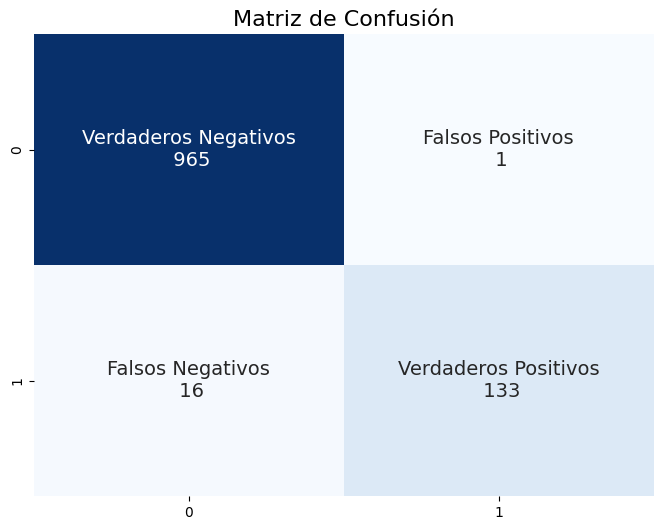

Accuracy:	98.48%
Precision:	99.25%
Recall:		89.26%
F1 Score:	93.99%


In [24]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

#Accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

#Precision
precision = precision_score(y_true=y_test, y_pred=y_pred)

#Recall
recall = recall_score(y_true=y_test, y_pred=y_pred)

#F1 score
f1 = f1_score(y_true=y_test, y_pred=y_pred)

print("\nMatriz de Confusión:")

# Define las etiquetas para los valores en la matriz de confusión
labels = [['Verdaderos Negativos\n', 'Falsos Positivos\n'],
          ['Falsos Negativos\n', 'Verdaderos Positivos\n']]

# Crear una nueva matriz combinando la matriz de confusión y las etiquetas
annot_matrix = [['{} {}'.format(label, value) for label, value in zip(row_labels, row)] for row_labels, row in zip(labels, conf_matrix)]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=annot_matrix, cmap='Blues', fmt='', cbar=False, annot_kws={'size':14})
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

print("Accuracy:\t{:.2%}".format(accuracy))
print("Precision:\t{:.2%}".format(precision))
print("Recall:\t\t{:.2%}".format(recall))
print("F1 Score:\t{:.2%}".format(f1))
